Positive advection speed:[ 2.  4.  6.]
Negative advection speed:[ 1.  3.  5.]
Choose your initial condition 4



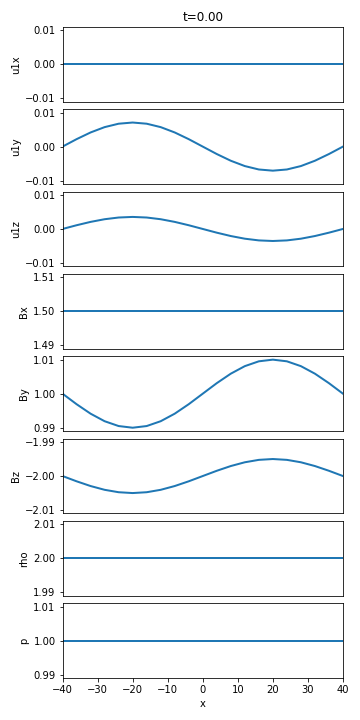
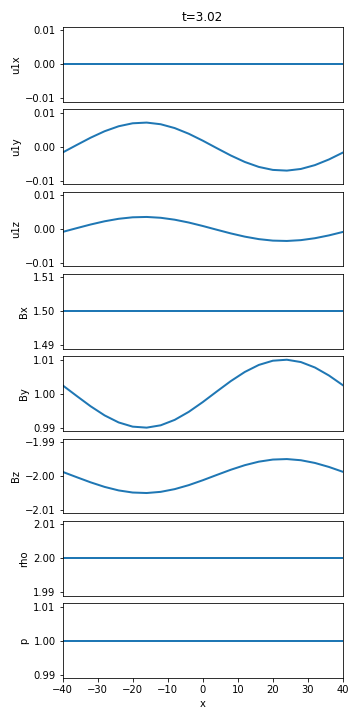
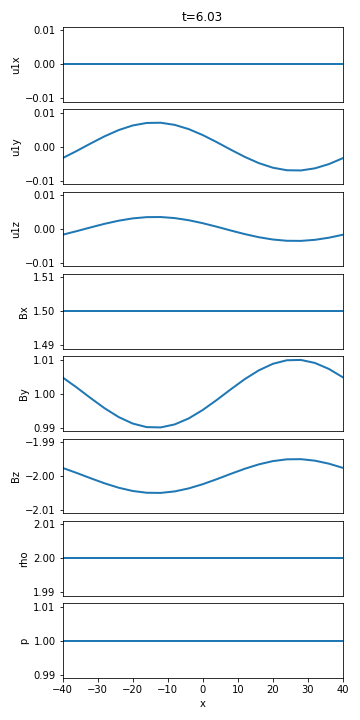
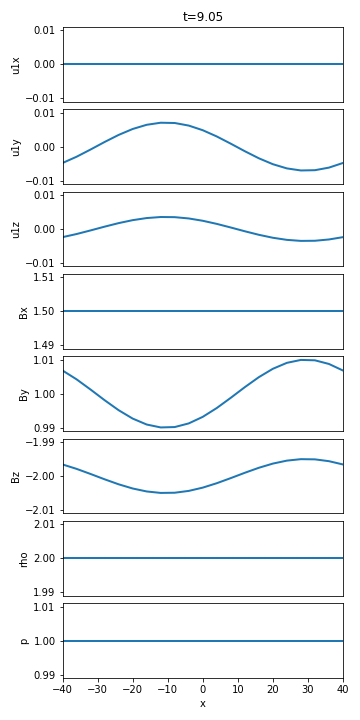
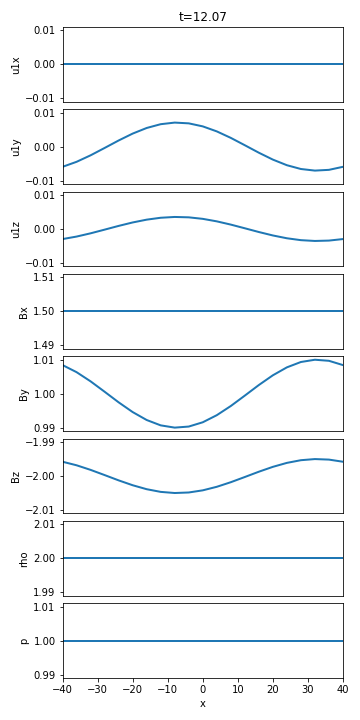
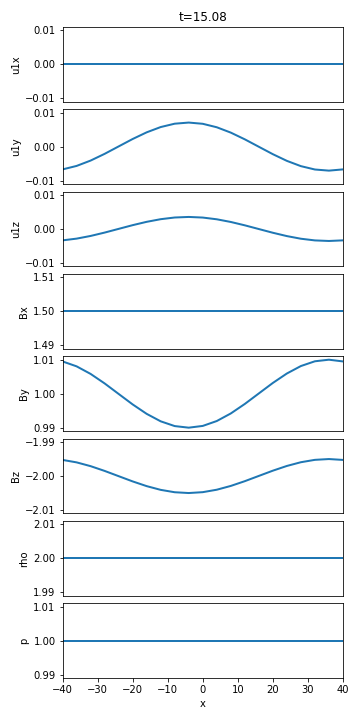
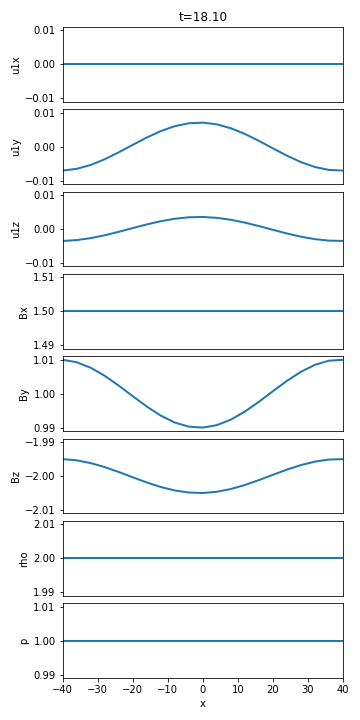
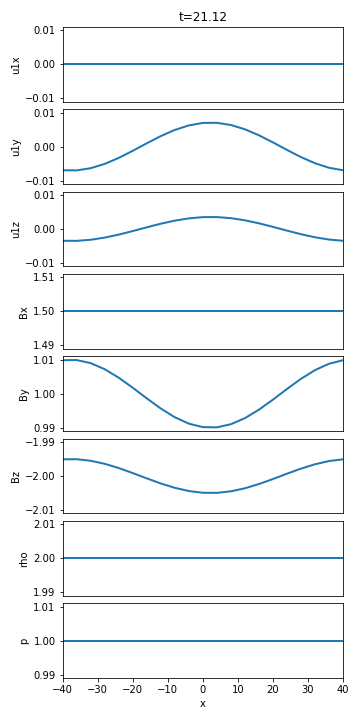
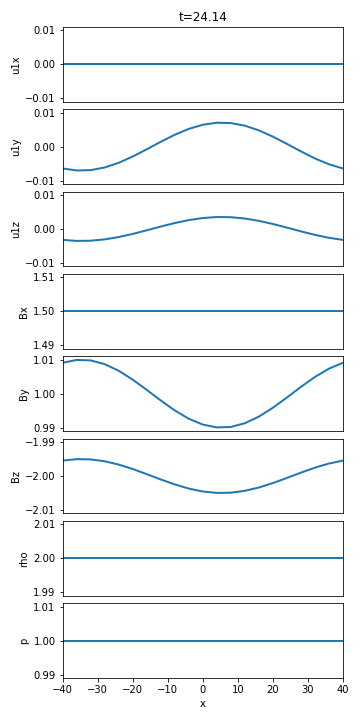
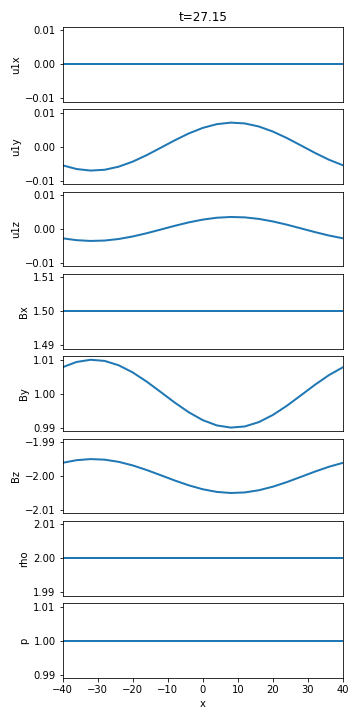
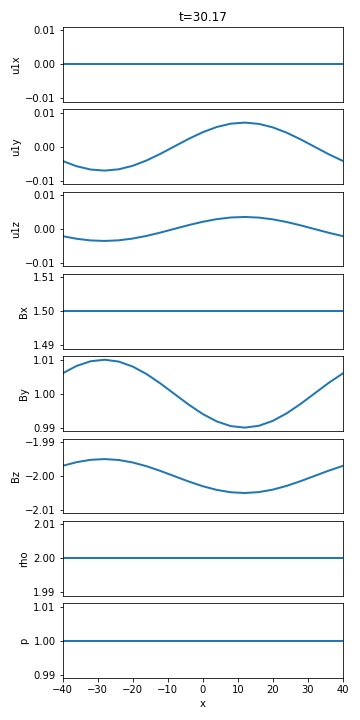
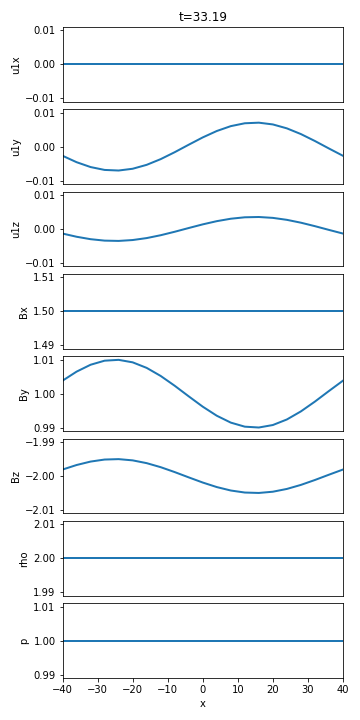
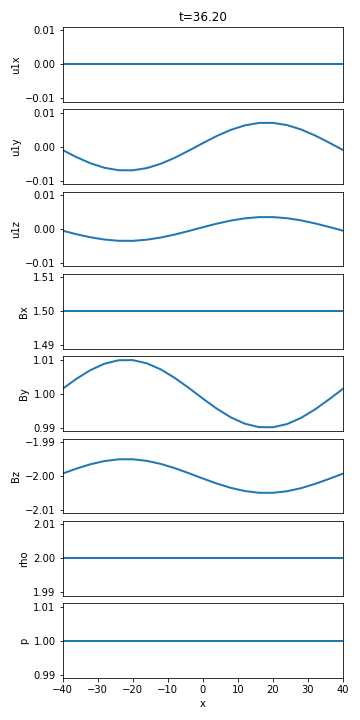
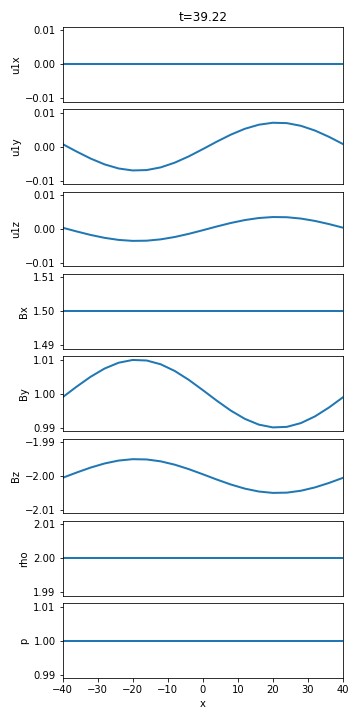
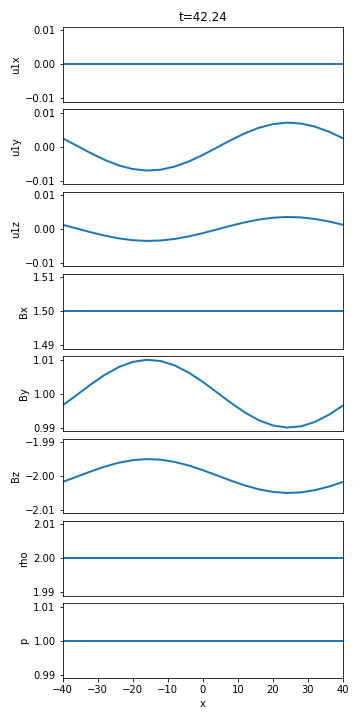
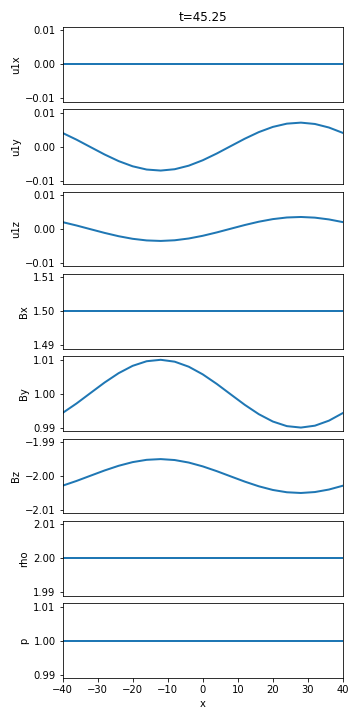
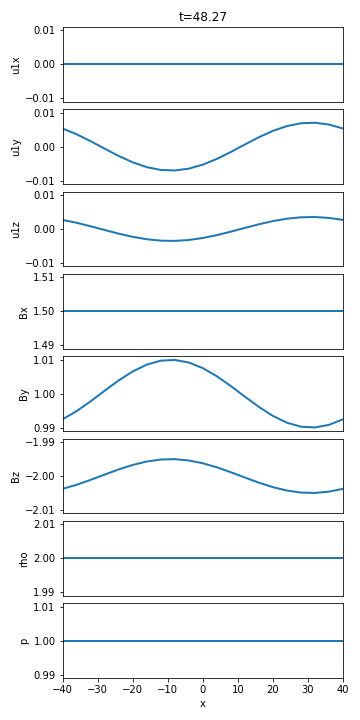
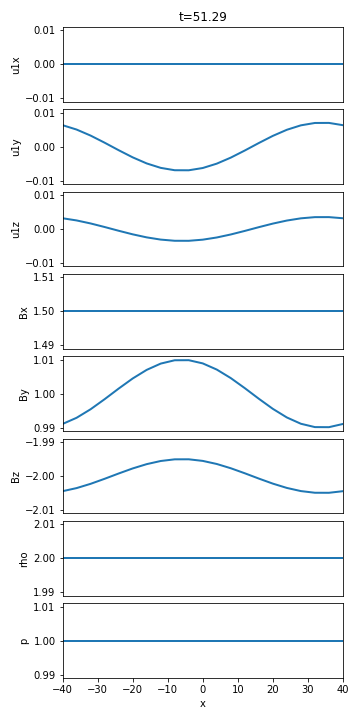
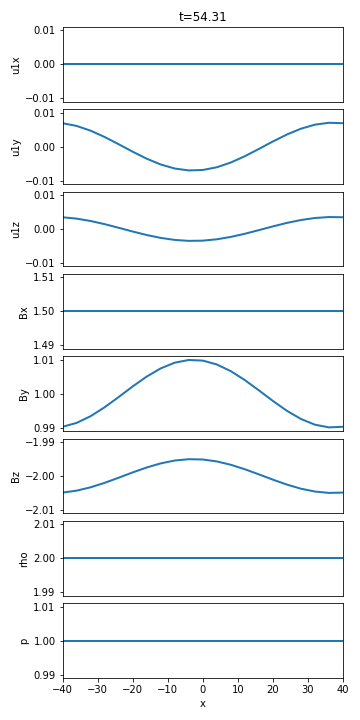
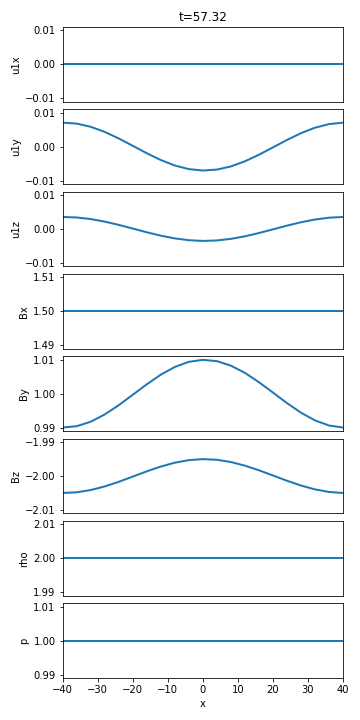
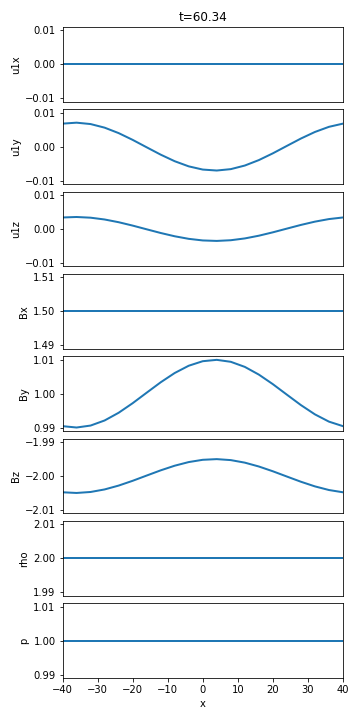
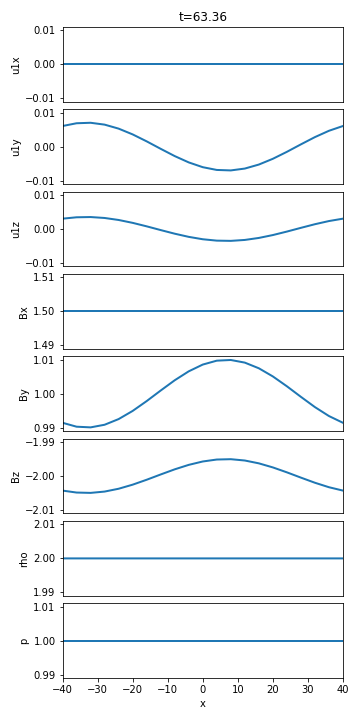
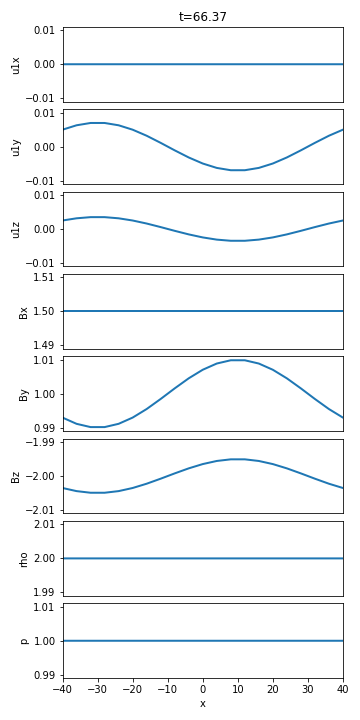
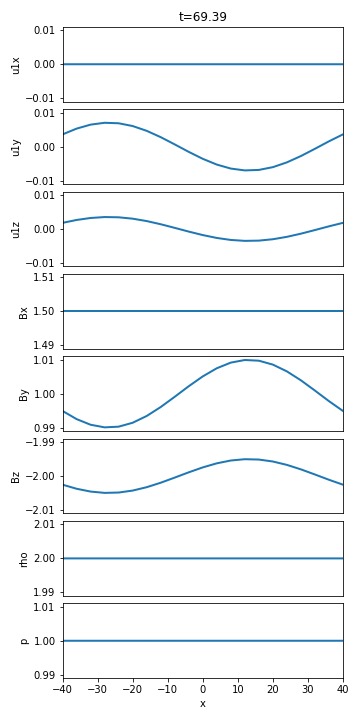
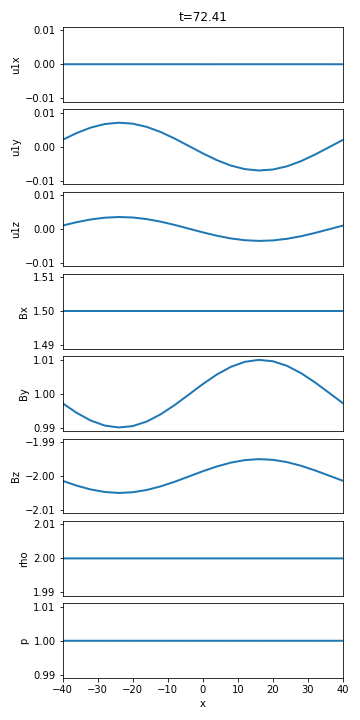
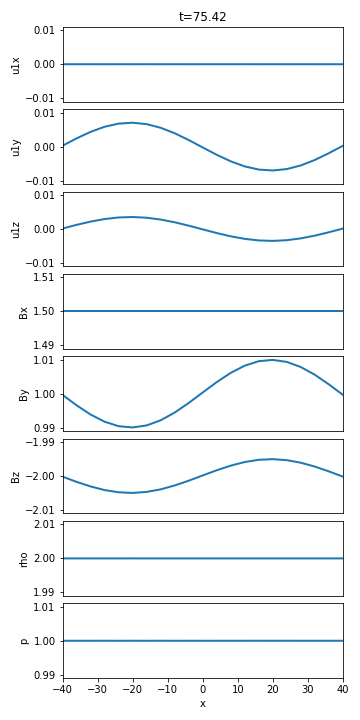
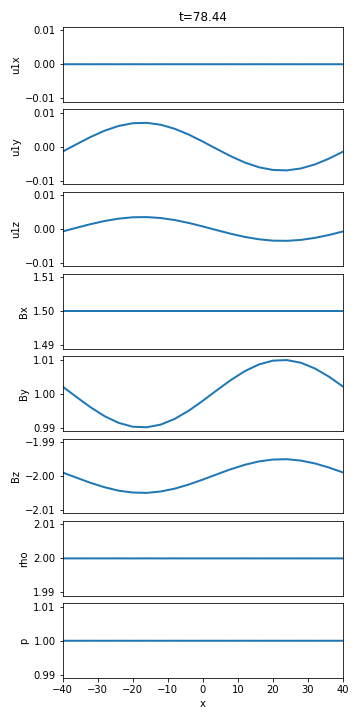
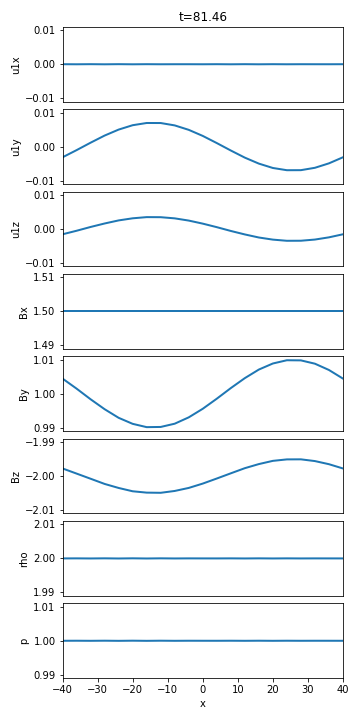
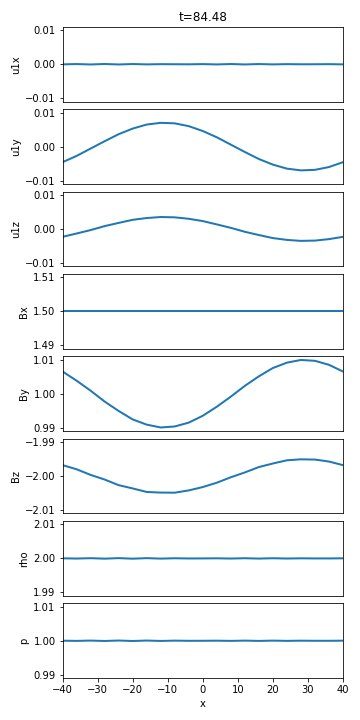
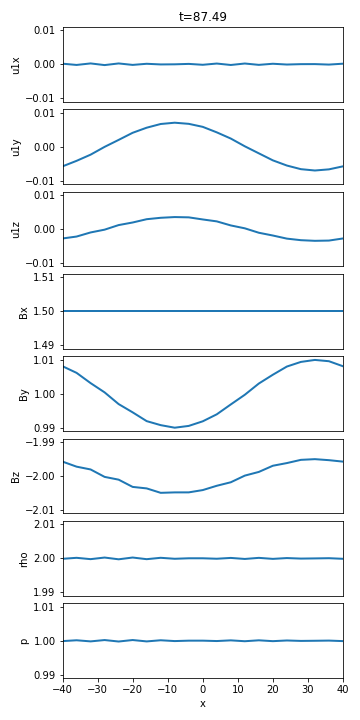
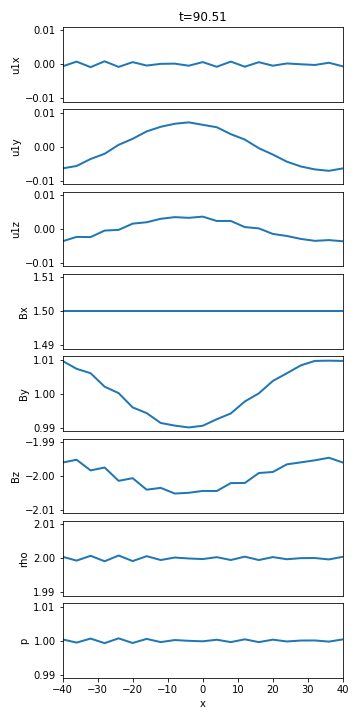
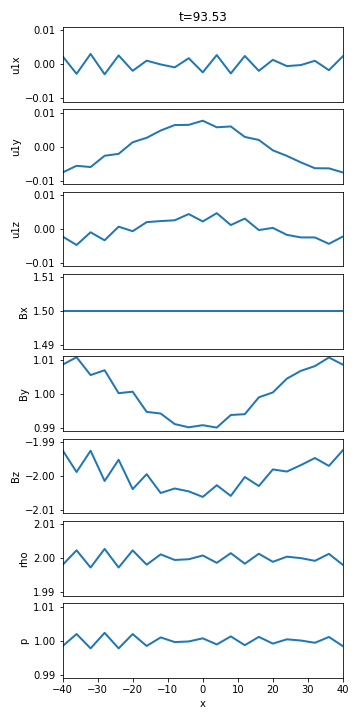
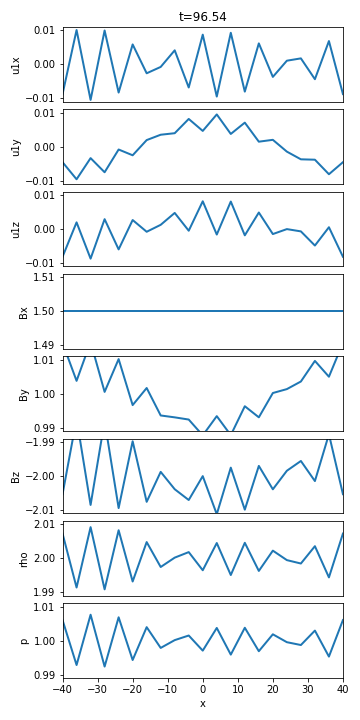
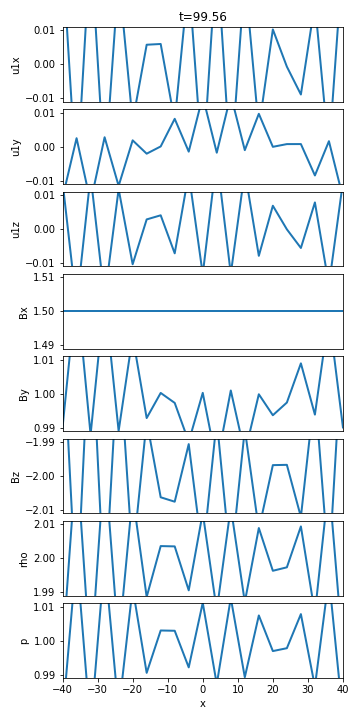

In [9]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from JSAnimation import IPython_display
from matplotlib import animation
from scipy.linalg import block_diag
from numpy.linalg import inv
from numpy import linalg as LA
from scipy.linalg import expm, sinm, cosm



#This script contains methods for simulations of linear Alfvén and sound waves
#Model: A homogeneous plasma with mass density rho0 and pressure p0 in a constant magnetic field B0 in one dimension

#Author: Florian Holderied
#Last update: 23.02.2018




#Input Parameters
rho0=1                    #Mass density of plasma
p0=1                      #Pressure of plasma
B0x=1                     #Background magnetic field x
B0y=0                     #Background magnetic field y
B0z=0                     #Background magnetic field z
gamma=5/3                 #Adiabatic exponent
a=0.01                    #Amplitude of pertubations
L=40                      #Length of x-domain in + and - direction (L_tot=2L)
T=100                     #Simulation time
Nx=20                     #Number of grid cells in x-direction
CFL=1                     #CFL-condition
func=1                    #Shaped of initial condition (1: sine-shaped, 2: 1/cosh-shaped)
method='Spectral'         #Choose your method (ExplicitUpwind,ImplicitUpwind,LaxWendroff,LaxFriedrichs,Spectral)






#System matrix
A=np.array([[0,0,0,0,B0y/rho0,B0z/rho0,0,1/(2*rho0)],[0,0,0,0,-B0x/rho0,0,0,0],[0,0,0,0,0,-B0x/rho0,0,0],[0,0,0,0,0,0,0,0],[B0y,-B0x,0,0,0,0,0,0],[B0z,0,-B0x,0,0,0,0,0],[rho0,0,0,0,0,0,0,0],[p0*gamma,0,0,0,0,0,0,0]])



#Eigenvalues (Advection speed) and eigenvectors (initial conditions)
v,w=LA.eig(A)
indicespos=np.array([])
indicesneg=np.array([])


#Sort by positve and negative advection speeds
for i in range(0,v.size):
    if v[i]>0:
        indicespos=np.append(indicespos,i)
    elif v[i]<0:
        indicesneg=np.append(indicesneg,i)
        

#Choice of initial condition        
print('Positive advection speed:'+str(indicespos))
print('Negative advection speed:'+str(indicesneg))
initial=int(input("Choose your initial condition ")) 


#Normalisation of inital condition
U0=a*w[:,initial]/np.amax(abs(w[:,initial]))
v=v[initial]



#Initial condition for Finite Differences
def initial_Conditions(x,fun):
    if fun==1:
        return np.outer(U0,np.sin(x*np.pi/L))
    elif fun==2:
        return np.outer(U0,1/np.cosh(40*x/L))





    
       
#Explicit upwind scheme with matrix notation U=(u1x,u1y,u1z,B1x,B1y,B1z,rho1,p1)
def explicit_Upwind(L,T,Nx,CFL,A,v,initial_Conditions,func):
    deltax=2*L/Nx
    deltat=CFL*deltax/np.abs(v)
    Nt=np.int(T/deltat)
    x=np.linspace(-L,L,Nx+1)
    x=np.delete(x,-1)
    s=int(np.sqrt(A.size))
    U=np.zeros((Nx,s,Nt+1))
    IC=initial_Conditions(x,func)
    U[:,:,0]=np.transpose(IC)
    U=np.reshape(U,(s*Nx,Nt+1))
    
    if v>0:
        B=deltat/deltax*A
        Tr=np.zeros((s*Nx,s*Nx))
        Tr2=block_diag(*([np.identity(s)-B]*Nx))
        F=block_diag(*([B]*(Nx-1)))
        Tr[s:s*Nx,0:s*Nx-s]=F
        Tr[0:s,s*Nx-s:s*Nx]=B
        Tr=Tr+Tr2
    
        for n in range(0,U[0,:].size-1):
            U[:,n+1]=np.dot(Tr,U[:,n])
            
    elif v<0:
        B=deltat/deltax*A
        Tr=np.zeros((s*Nx,s*Nx))
        Tr2=block_diag(*([np.identity(s)+B]*Nx))
        F=block_diag(*([-B]*(Nx-1)))
        Tr[0:s*Nx-s,s:s*Nx]=F
        Tr[s*Nx-s:s*Nx,0:s]=-B
        Tr=Tr+Tr2
        
        for n in range(0,U[0,:].size-1):
            U[:,n+1]=np.dot(Tr,U[:,n])
    
    Temp=np.zeros((s*Nx+s,Nt+1))
    Temp[0:s*Nx,:]=U
    Temp[s*Nx:s*Nx+s]=U[0:s,:]
    Temp=np.reshape(Temp,(Nx+1,s,Nt+1))
    
    return Temp







#Implicit upwind scheme with matrix notation U=(u1x,u1y,u1z,B1x,B1y,B1z,rho1,p1)
def implicit_Upwind(L,T,Nx,CFL,A,v,initial_Conditions,func):
    deltax=2*L/Nx
    deltat=CFL*deltax/np.abs(v)
    Nt=np.int(T/deltat)
    x=np.linspace(-L,L,Nx+1)
    x=np.delete(x,-1)
    s=int(np.sqrt(A.size))
    U=np.zeros((Nx,s,Nt+1))
    IC=initial_Conditions(x,func)
    U[:,:,0]=np.transpose(IC)
    U=np.reshape(U,(s*Nx,Nt+1))
    
    if v>0:
        B=deltat/deltax*A
        Tr=np.zeros((s*Nx,s*Nx))
        Tr2=block_diag(*([np.identity(s)+B]*Nx))
        F=block_diag(*([-B]*(Nx-1)))
        Tr[s:s*Nx,0:s*Nx-s]=F
        Tr[0:s,s*Nx-s:s*Nx]=-B
        Tr=Tr+Tr2
        ID=np.identity(s)
        
        for n in range(0,Nx-1):
            Temp1=np.identity(s)
            ID=np.append(ID,Temp1,axis=0)
    
        ID=np.transpose(ID)
        Tr[s*Nx-s:s*Nx,:]=ID
    
        for n in range(0,U[0,:].size-1):
            Temp2=np.zeros(s*Nx+1)
            Temp2[0:s*Nx]=U[:,n]
            Temp2[s*Nx-s:s*Nx]=0
            Temp2=np.delete(Temp2,-1)
            U[:,n+1]=np.dot(inv(Tr),Temp2)
    
    if v<0:
        B=deltat/deltax*A
        Tr=np.zeros((s*Nx,s*Nx))
        Tr2=block_diag(*([np.identity(s)-B]*Nx))
        F=block_diag(*([B]*(Nx-1)))
        Tr[0:s*Nx-s,s:s*Nx,]=F
        Tr[s*Nx-s:s*Nx,0:s,]=B
        Tr=Tr+Tr2
        ID=np.identity(s)
        
        for n in range(0,Nx-1):
            Temp1=np.identity(s)
            ID=np.append(ID,Temp1,axis=0)
    
        ID=np.transpose(ID)
        Tr[s*Nx-s:s*Nx,:]=ID
    
        for n in range(0,U[0,:].size-1):
            Temp2=np.zeros(s*Nx+1)
            Temp2[0:s*Nx]=U[:,n]
            Temp2[s*Nx-s:s*Nx]=0
            Temp2=np.delete(Temp2,-1)
            U[:,n+1]=np.dot(inv(Tr),Temp2)
                
    Temp=np.zeros((s*Nx+s,Nt+1))
    Temp[0:s*Nx,:]=U
    Temp[s*Nx:s*Nx+s]=U[0:s,:]
    Temp=np.reshape(Temp,(Nx+1,s,Nt+1))
    
    return Temp








#Lax-Friedrichs scheme with matrix notation U=(u1x,u1y,u1z,B1x,B1y,B1z,rho1,p1)
def Lax_Friedrichs(L,T,Nx,CFL,A,v,initial_Conditions,func):
    deltax=2*L/Nx
    deltat=CFL*deltax/np.abs(v)
    Nt=np.int(T/deltat)
    x=np.linspace(-L,L,Nx+1)
    x=np.delete(x,-1)
    s=int(np.sqrt(A.size))
    U=np.zeros((Nx,s,Nt+1))
    IC=initial_Conditions(x,func)
    U[:,:,0]=np.transpose(IC)
    U=np.reshape(U,(s*Nx,Nt+1))
    
    B=deltat/(2*deltax)*A
    B1=0.5*np.identity(s)-B
    B2=0.5*np.identity(s)+B
    Temp1=np.zeros((s*Nx,s*Nx))
    Temp2=np.zeros((s*Nx,s*Nx))
    F1=block_diag(*([B1]*(Nx-1)))
    F2=block_diag(*([B2]*(Nx-1)))
    Temp1[0:s*Nx-s,s:s*Nx]=F1
    Temp1[-s:s*Nx,0:s]=B1
    Temp2[s:s*Nx,0:s*Nx-s]=F2
    Temp2[0:s,-s:s*Nx]=B2
    Tr=Temp1+Temp2
    
    for n in range(0,U[0,:].size-1):
        U[:,n+1]=np.dot(Tr,U[:,n])
            
    Temp=np.zeros((s*Nx+s,Nt+1))
    Temp[0:s*Nx,:]=U
    Temp[s*Nx:s*Nx+s]=U[0:s,:]
    Temp=np.reshape(Temp,(Nx+1,s,Nt+1))
    
    return Temp







#Lax-Wendroff scheme with matrix notation U=(u1x,u1y,u1z,B1x,B1y,B1z,rho1,p1)
def Lax_Wendroff(L,T,Nx,CFL,A,v,initial_Conditions,func):
    deltax=2*L/Nx
    deltat=CFL*deltax/np.abs(v)
    Nt=np.int(T/deltat)
    x=np.linspace(-L,L,Nx+1)
    x=np.delete(x,-1)
    s=int(np.sqrt(A.size))
    U=np.zeros((Nx,s,Nt+1))
    IC=initial_Conditions(x,func)
    U[:,:,0]=np.transpose(IC)
    U=np.reshape(U,(s*Nx,Nt+1))
    
    Temp1=np.zeros((s*Nx,s*Nx))
    Temp2=np.zeros((s*Nx,s*Nx))
    B1=np.identity(s)-((deltat/deltax)**2)*np.dot(A,A)
    B2=(0.5*(deltat/deltax)**2)*np.dot(A,A)-(deltat/(2*deltax))*A
    B3=(0.5*(deltat/deltax)**2)*np.dot(A,A)+(deltat/(2*deltax))*A
    
    F1=block_diag(*([B1]*Nx))
    F2=block_diag(*([B2]*(Nx-1))) 
    F3=block_diag(*([B3]*(Nx-1))) 
    Temp1[0:s*Nx-s,s:s*Nx]=F2  
    Temp2[s:s*Nx,0:s*Nx-s]=F3
    Temp2[s*Nx-s:s*Nx,0:s]=B2
    Temp2[0:s,s*Nx-s:s*Nx]=B3
    Tr=F1+Temp1+Temp2
    
    for n in range(0,U[0,:].size-1):
        U[:,n+1]=np.dot(Tr,U[:,n])
        
    Temp=np.zeros((s*Nx+s,Nt+1))
    Temp[0:s*Nx,:]=U
    Temp[s*Nx:s*Nx+s]=U[0:s,:]
    Temp=np.reshape(Temp,(Nx+1,s,Nt+1))
    
    return Temp






#Spectral scheme with matrix notation U=(u1x,u1y,u1z,B1x,B1y,B1z,rho1,p1)
def Spectral(L,T,Nx,CFL,A,v,initial_Conditions,func):
    deltax=2*L/Nx
    deltat=CFL*deltax/np.abs(v)
    Nt=np.int(T/deltat)
    x=np.linspace(-L,L,Nx+1)
    x=np.delete(x,-1)
    s=int(np.sqrt(A.size))
    U=np.zeros((Nx,s,Nt+1),dtype=complex)
    IC=initial_Conditions(x,func)
    U[:,:,0]=np.transpose(IC)
    kindices=np.fft.fftshift(np.linspace(1,Nx,Nx)-Nx/2-1)
    k=2*np.pi/(2*L)*kindices

    for n in range(0,Nt):
        Uk=np.transpose(np.fft.fft(np.transpose(U[:,:,n])))
        Uk=np.reshape(Uk,s*Nx)
        
        for l in range(0,Nx):
            if l==0:
                propagator=expm(-1j*A*deltat*k[l])
                Uk[l:l+s]=np.dot(propagator,Uk[l:l+s])
            else:
                i=l*s
                propagator=expm(-1j*A*deltat*k[l])
                Uk[i:i+s]=np.dot(propagator,Uk[i:i+s])               
            
        Uk=np.reshape(Uk,(Nx,s))
        U[:,:,n+1]=np.transpose(np.fft.ifft(np.transpose(Uk)))

    U=np.reshape(U,(s*Nx,Nt+1))   
    Temp=np.zeros((s*Nx+s,Nt+1),dtype=complex)
    Temp[0:s*Nx,:]=U
    Temp[s*Nx:s*Nx+s]=U[0:s,:]
    Temp=np.reshape(Temp,(Nx+1,s,Nt+1))
    
    return Temp





if method=='ExplicitUpwind':
    Test=explicit_Upwind(L,T,Nx,CFL,A,v,initial_Conditions,func)
elif method=='ImplicitUpwind':
    Test=implicit_Upwind(L,T,Nx,CFL,A,v,initial_Conditions,func)
elif method=='LaxFriedrichs':
    Test=Lax_Friedrichs(L,T,Nx,CFL,A,v,initial_Conditions,func)  
elif method=='LaxWendroff':
    Test=Lax_Wendroff(L,T,Nx,CFL,A,v,initial_Conditions,func)  
elif method=='Spectral':
    Test=np.real(Spectral(L,T,Nx,CFL,A,v,initial_Conditions,func))   

 


    
#Discretisation of space and time for Animation
deltax=2*L/Nx
deltat=CFL*deltax/np.abs(v)
Nt=np.int(T/deltat)
T=Nt*deltat
x=np.linspace(-L,L,Nx+1)
t=np.linspace(0,T,Nt+1)


# Animation    
f, (a1, a2, a3, a4, a5, a6, a7, a8) = plt.subplots(8,1,sharex=True)
f.set_figheight(10)
f.set_figwidth(5)
a1.set_title('t=0.00')
a1.set_xlim((-L,L))
a2.set_xlim((-L,L))
a3.set_xlim((-L,L))
a4.set_xlim((-L,L))
a5.set_xlim((-L,L))
a6.set_xlim((-L,L))
a7.set_xlim((-L,L))
a8.set_xlim((-L,L))
a1.set_ylim((-a-0.001,a+0.001))
a2.set_ylim((-a-0.001,a+0.001))
a3.set_ylim((-a-0.001,a+0.001))
a4.set_ylim((B0x-a-0.001,B0x+a+0.001))
a5.set_ylim((B0y-a-0.001,B0y+a+0.001))
a6.set_ylim((B0z-a-0.001,B0z+a+0.001))
a7.set_ylim((rho0-a-0.001,rho0+a+0.001))
a8.set_ylim((p0-a-0.001,p0+a+0.001))
a1.set_ylabel('u1x')
a2.set_ylabel('u1y')
a3.set_ylabel('u1z')
a4.set_ylabel('Bx')
a5.set_ylabel('By')
a6.set_ylabel('Bz')
a7.set_ylabel('rho')
a8.set_ylabel('p')
a1.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off') 
a2.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off') 
a3.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off') 
a4.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off') 
a5.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off') 
a6.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off') 
a7.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off') 
line1,=a1.plot([],[], lw=2)
line2,=a2.plot([],[], lw=2)
line3,=a3.plot([],[], lw=2)
line4,=a4.plot([],[], lw=2)
line5,=a5.plot([],[], lw=2)
line6,=a6.plot([],[], lw=2)
line7,=a7.plot([],[], lw=2)
line8,=a8.plot([],[], lw=2)
a8.set_xlabel('x')
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0.1)

def init():  
    line1.set_data([], [])
    line2.set_data([], [])
    line3.set_data([], [])
    line4.set_data([], [])
    line5.set_data([], [])
    line6.set_data([], [])
    line7.set_data([], [])
    line8.set_data([], [])
    return line1,

def animate(i):
    line1.set_data(x,Test[:,0,i])
    line2.set_data(x,Test[:,1,i])
    line3.set_data(x,Test[:,2,i])
    line4.set_data(x,Test[:,3,i]+B0x)
    line5.set_data(x,Test[:,4,i]+B0y)
    line6.set_data(x,Test[:,5,i]+B0z)
    line7.set_data(x,Test[:,6,i]+rho0)
    line8.set_data(x,Test[:,7,i]+p0)
    a1.set_title('t='+'%.2f' % t[i])
    return line1,

animation.FuncAnimation(f, animate, init_func=init, frames=Nt+1, interval=50, blit=True)